In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#there are some irregular lines in the data, so setting argument to get a note of which lines and skip them when reading in
accre_gpu = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='warn')

b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


In [3]:
accre_gpu

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING
336946,46754542,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336947,46754560,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336948,46754598,glasshouse,treva,145.24M,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED


In [4]:
accre_gpu.info()
#looking at our dataframe, we will need to adjust some data types to allow calculations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      336950 non-null  object
 1   ACCOUNT    336950 non-null  object
 2   USER       336950 non-null  object
 3   USEDMEM    336950 non-null  object
 4   REQTIME    336950 non-null  object
 5   USEDTIME   336950 non-null  object
 6   NODES      336950 non-null  int64 
 7   CPUS       336950 non-null  int64 
 8   GPUS       336950 non-null  int64 
 9   PARTITION  336950 non-null  object
 10  EXITCODE   336950 non-null  object
 11  STATE      336950 non-null  object
dtypes: int64(3), object(9)
memory usage: 30.8+ MB


In [5]:
#per our stakeholder, no need to include jobs with state of pending or running in our analysis, so dropping those 1258 rows
accre_gpu = accre_gpu.loc[~accre_gpu['STATE'].isin(['PENDING', 'RUNNING'])]

In [6]:
#Confirming that for the USEDMEM column, any values that do not include 'M' are zeroes before stripping the M
accre_gpu.loc[~accre_gpu['USEDMEM'].str.contains('M')]['USEDMEM'].value_counts().sort_values()

0    57489
Name: USEDMEM, dtype: int64

In [7]:
#stripping the 'M' from USEDMEM column and converting it to a numeric data type
accre_gpu['USEDMEM'] = accre_gpu['USEDMEM'].str.strip(to_strip='M').astype(float)

#converting REQTIME and USEDTIME columns to timedelta data types
accre_gpu['REQTIME'] = pd.to_timedelta(accre_gpu['REQTIME'].str.replace('-',' days '))
accre_gpu['USEDTIME'] = pd.to_timedelta(accre_gpu['USEDTIME'].str.replace('-',' days '))
#adding in a column that gives the difference in the time requested and time used
accre_gpu['time_dif'] = accre_gpu['REQTIME'] - accre_gpu['USEDTIME']

#adding in columns that provide versions of the other time columns but in seconds
accre_gpu['REQTIME_sec'] = accre_gpu['REQTIME'].dt.total_seconds()
accre_gpu['USEDTIME_sec'] = accre_gpu['USEDTIME'].dt.total_seconds()
accre_gpu['time_dif_sec'] = accre_gpu['REQTIME_sec'] - accre_gpu['USEDTIME_sec']

accre_gpu.info()

C:\Users\mews2\AppData\Local\Temp\ipykernel_8844\4264271925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accre_gpu['USEDMEM'] = accre_gpu['USEDMEM'].str.strip(to_strip='M').astype(float)
C:\Users\mews2\AppData\Local\Temp\ipykernel_8844\4264271925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accre_gpu['REQTIME'] = pd.to_timedelta(accre_gpu['REQTIME'].str.replace('-',' days '))
C:\Users\mews2\AppData\Local\Temp\ipykernel_8844\4264271925.py:6: SettingWithCopyWarning: 
A value is trying to be set 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335692 entries, 0 to 336948
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype          
---  ------        --------------   -----          
 0   JOBID         335692 non-null  object         
 1   ACCOUNT       335692 non-null  object         
 2   USER          335692 non-null  object         
 3   USEDMEM       335692 non-null  float64        
 4   REQTIME       335692 non-null  timedelta64[ns]
 5   USEDTIME      335692 non-null  timedelta64[ns]
 6   NODES         335692 non-null  int64          
 7   CPUS          335692 non-null  int64          
 8   GPUS          335692 non-null  int64          
 9   PARTITION     335692 non-null  object         
 10  EXITCODE      335692 non-null  object         
 11  STATE         335692 non-null  object         
 12  time_dif      335692 non-null  timedelta64[ns]
 13  REQTIME_sec   335692 non-null  float64        
 14  USEDTIME_sec  335692 non-null  float64        
 15  

Doing a little exploration of the values in our columns

In [8]:
accre_gpu['STATE'].value_counts().sort_index(ascending=False)

OUT_OF_MEMORY               3
FAILED                    440
COMPLETED              283333
CANCELLED by 9201       41637
CANCELLED by 913169         3
                        ...  
CANCELLED by 153500         3
CANCELLED by 133418        23
CANCELLED by 111694        11
CANCELLED by 0              1
CANCELLED                 947
Name: STATE, Length: 96, dtype: int64

After dropping jobs marked as pending or running, these are the STATE column values that remain:   
- Out of memory
- Failed
- Completed
- Cancelled
- Cancelled by [numerical code] (92 versions of this)

Exploring the jobs that show some version of a Cancelled state

In [9]:
cancelled = accre_gpu.loc[accre_gpu['STATE'].str.contains('CANCELLED')]
cancelled

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
8,32880758,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
9,32880759,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
10,32880770,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
11,32880771,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
12,32880772,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336807,46745418,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
336830,46745779,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
336832,46745783,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
336880,46752723,glasshouse,ethen,0.0,0 days 04:00:00,0 days,1,6,1,turing,0:0,CANCELLED by 899035,0 days 04:00:00,14400.0,0.0,14400.0


There are 51,916 jobs that have a STATE value of some version of Cancelled. May be worth looking at how much time and memory was spent on these jobs

In [10]:
#taking a quick look just to see how many of the cancelled jobs ran for more than an hour
cancelled.loc[cancelled['USEDTIME'] > '01:00:00'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,295.000000,295,295,295.000000,295.000000,295.000000,295,2.950000e+02,295.000000,2.950000e+02
mean,7370.163051,3 days 21:08:32.542372881,2 days 10:20:31.593220338,1.471186,5.501695,4.962712,1 days 10:48:00.949152542,3.353125e+05,210031.593220,1.252809e+05
std,11668.831393,1 days 22:49:35.663623084,2 days 01:15:01.972778381,1.016037,5.861714,4.923424,2 days 00:51:34.763658105,1.685757e+05,177301.972778,1.758948e+05
min,0.000000,0 days 01:00:00,0 days 01:03:22,1.000000,1.000000,1.000000,-1 days +23:51:22,3.600000e+03,3802.000000,-5.180000e+02
25%,203.060000,2 days 00:00:00,0 days 07:57:40,1.000000,1.000000,1.000000,-1 days +23:59:40,1.728000e+05,28660.000000,-2.000000e+01
50%,1236.400000,5 days 00:00:00,2 days 00:00:38,1.000000,4.000000,4.000000,0 days 01:46:54,4.320000e+05,172838.000000,6.414000e+03
75%,9216.925000,5 days 00:00:00,5 days 00:00:02,1.000000,8.000000,5.000000,2 days 17:31:53.500000,4.320000e+05,432002.000000,2.359135e+05
max,54338.440000,15 days 00:00:00,9 days 23:59:54,4.000000,33.000000,16.000000,13 days 07:38:06,1.296000e+06,863994.000000,1.150686e+06


Only 295 Cancelled jobs ran for longer than an hour but the mean and median for these is around 2 days, so, again, may be worth exploring to better understand them and see if such instances can be avoided

In [11]:
cancelled.loc[cancelled['USEDTIME'] > '01:00:00'].groupby(['STATE','EXITCODE']).count()

JOBID  ACCOUNT  USER  USEDMEM  REQTIME  \
STATE               EXITCODE                                           
CANCELLED           0:0          53       53    53       53       53   
                    0:15         96       96    96       96       96   
                    0:6           9        9     9        9        9   
                    0:7           1        1     1        1        1   
                    0:9         114      114   114      114      114   
                    1:0           2        2     2        2        2   
CANCELLED by 505355 0:9           9        9     9        9        9   
CANCELLED by 756088 0:9           1        1     1        1        1   
CANCELLED by 785491 0:9           6        6     6        6        6   
CANCELLED by 859439 0:9           1        1     1        1        1   
CANCELLED by 885613 0:9           3        3     3        3        3   

                              USEDTIME  NODES  CPUS  GPUS  PARTITION  \
STATE               EXITCODE                                           
CANCELLED           0:0             53     53    53    53         53   
                    0:15            96     96    96    96         96   
                    0:6              9      9     9     9          9   
                    0:7              1      1     1     1          1   
                    0:9            114    114   114   114        114   
                    1:0              2      2     2     2          2   
CANCELLED by 505355 0:9              9      9     9     9          9   
CANCELLED by 756088 0:9              1      1     1     1          1   
CANCELLED by 785491 0:9              6      6     6     6          6   
CANCELLED by 859439 0:9              1      1     1     1          1   
CANCELLED by 885613 0:9              3      3     3     3          3   

                              time_dif  REQTIME_sec  USEDTIME_sec  \
STATE               EXITCODE                                        
CANCELLED           0:0             53           53            53   
                    0:15            96           96            96   
                    0:6              9            9             9   
                    0:7              1            1             1   
                    0:9            114          114           114   
                    1:0              2            2             2   
CANCELLED by 505355 0:9              9            9             9   
CANCELLED by 756088 0:9              1            1             1   
CANCELLED by 785491 0:9              6            6             6   
CANCELLED by 859439 0:9              1            1             1   
CANCELLED by 885613 0:9              3            3             3   

                              time_dif_sec  
STATE               EXITCODE                
CANCELLED           0:0                 53  
                    0:15                96  
                    0:6                  9  
                    0:7                  1  
                    0:9                114  
                    1:0                  2  
CANCELLED by 505355 0:9                  9  
CANCELLED by 756088 0:9                  1  
CANCELLED by 785491 0:9                  6  
CANCELLED by 859439 0:9                  1  
CANCELLED by 885613 0:9                  3

Do these exit codes suggest that there tends to be an issue with the environment that is associated with the job being cancelled?

Shifting gears back to the primary dataset

In [12]:
#per our stakeholder, CANCELLED jobs can be excluded from the main analysis, so dropping them from the primary dataframe
accre_gpu = accre_gpu.loc[~accre_gpu['STATE'].str.contains('CANCELLED')]
accre_gpu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283776 entries, 0 to 336948
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype          
---  ------        --------------   -----          
 0   JOBID         283776 non-null  object         
 1   ACCOUNT       283776 non-null  object         
 2   USER          283776 non-null  object         
 3   USEDMEM       283776 non-null  float64        
 4   REQTIME       283776 non-null  timedelta64[ns]
 5   USEDTIME      283776 non-null  timedelta64[ns]
 6   NODES         283776 non-null  int64          
 7   CPUS          283776 non-null  int64          
 8   GPUS          283776 non-null  int64          
 9   PARTITION     283776 non-null  object         
 10  EXITCODE      283776 non-null  object         
 11  STATE         283776 non-null  object         
 12  time_dif      283776 non-null  timedelta64[ns]
 13  REQTIME_sec   283776 non-null  float64        
 14  USEDTIME_sec  283776 non-null  float64        
 15  

In [13]:
accre_gpu['EXITCODE'].value_counts()

0:0      283334
1:0         395
2:0          17
127:0         6
7:0           6
13:0          5
126:0         4
16:0          3
0:125         3
33:0          2
9:0           1
Name: EXITCODE, dtype: int64

In [14]:
#Taking a look at the exit codes associated with failed jobs
accre_gpu.loc[accre_gpu['STATE'] == 'FAILED']['EXITCODE'].value_counts()

1:0      395
2:0       17
127:0      6
7:0        6
13:0       5
126:0      4
16:0       3
33:0       2
0:0        1
9:0        1
Name: EXITCODE, dtype: int64

Based on exit codes, the failed jobs seem to fail due to user side issues

In [15]:
#looking at overall distribution of values for our numerical/time columns
accre_gpu.describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,283776.000000,283776,283776,283776.000000,283776.000000,283776.000000,283776,2.837760e+05,2.837760e+05,2.837760e+05
mean,2261.094059,1 days 00:10:23.951496955,0 days 01:35:33.293763390,1.005490,1.724092,1.089324,0 days 22:34:50.657733564,8.702395e+04,5.733294e+03,8.129066e+04
std,6639.863578,1 days 11:32:30.215890212,0 days 09:56:52.751470501,0.128331,1.824853,0.859311,1 days 09:52:09.035932303,1.279502e+05,3.581275e+04,1.219290e+05
min,0.000000,0 days 00:01:00,0 days 00:00:00,0.000000,1.000000,1.000000,-49 days +01:13:05,6.000000e+01,0.000000e+00,-4.229215e+06
25%,7.530000,0 days 10:00:00,0 days 00:00:22,1.000000,1.000000,1.000000,0 days 05:59:43,3.600000e+04,2.200000e+01,2.158300e+04
50%,1176.710000,0 days 10:00:00,0 days 00:03:19,1.000000,1.000000,1.000000,0 days 09:57:06,3.600000e+04,1.990000e+02,3.582600e+04
75%,2179.940000,0 days 12:00:00,0 days 00:09:08,1.000000,2.000000,1.000000,0 days 11:39:33,4.320000e+04,5.480000e+02,4.197300e+04
max,371247.350000,15 days 00:00:00,49 days 02:46:55,15.000000,120.000000,60.000000,11 days 09:46:10,1.296000e+06,4.243615e+06,9.855700e+05


In [16]:
#interestingly, values slightly lower if only looking at completed jobs (no failed(440) or out of memory(3))
accre_gpu.loc[accre_gpu['STATE'] == 'COMPLETED'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,283333.000000,283333,283333,283333.000000,283333.000000,283333.000000,283333,2.833330e+05,283333.000000,283333.000000
mean,2240.911704,1 days 00:05:59.687223161,0 days 01:34:19.081218919,1.004779,1.713161,1.079627,0 days 22:31:40.606004242,8.675969e+04,5659.081219,81100.606004
std,6434.562929,1 days 11:29:35.285143482,0 days 09:38:43.694361307,0.115222,1.758140,0.783146,1 days 09:45:08.955143504,1.277753e+05,34723.694361,121508.955144
min,0.000000,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000,-1 days +03:56:07,6.000000e+01,0.000000,-72233.000000
25%,7.530000,0 days 10:00:00,0 days 00:00:22,1.000000,1.000000,1.000000,0 days 05:59:42,3.600000e+04,22.000000,21582.000000
50%,1176.880000,0 days 10:00:00,0 days 00:03:19,1.000000,1.000000,1.000000,0 days 09:57:06,3.600000e+04,199.000000,35826.000000
75%,2179.520000,0 days 12:00:00,0 days 00:09:06,1.000000,2.000000,1.000000,0 days 11:37:36,4.320000e+04,546.000000,41856.000000
max,371247.350000,15 days 00:00:00,8 days 03:15:34,15.000000,120.000000,60.000000,11 days 09:46:10,1.296000e+06,702934.000000,985570.000000


So much skew!

In [17]:
accre_gpu.nlargest(5, 'USEDTIME')

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
317705,45364680,glasshouse,daryl,0.00,0 days 04:00:00,49 days 02:46:55,1,2,1,pascal,0:0,FAILED,-49 days +01:13:05,14400.0,4243615.0,-4229215.0
82721,40954771,glasshouse,mel,7465.59,12 days 00:00:00,8 days 03:15:34,3,21,16,pascal,0:0,COMPLETED,3 days 20:44:26,1036800.0,702934.0,333866.0
330597,45754711_9,harovin,porsha,17932.89,5 days 00:00:00,5 days 00:04:26,1,6,1,turing,0:0,COMPLETED,-1 days +23:55:34,432000.0,432266.0,-266.0
330598,45754711_10,harovin,porsha,18744.37,5 days 00:00:00,5 days 00:04:25,1,6,1,turing,0:0,COMPLETED,-1 days +23:55:35,432000.0,432265.0,-265.0
59290,35860195,harovin,porsha,4045.17,5 days 00:00:00,5 days 00:02:24,1,3,1,turing,0:0,COMPLETED,-1 days +23:57:36,432000.0,432144.0,-144.0


In [18]:
accre_gpu.loc[accre_gpu['STATE'] != 'COMPLETED'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,443.000000,443,443,443.000000,443.000000,443.000000,443,443.000000,4.430000e+02,4.430000e+02
mean,15169.281535,2 days 23:07:21.534988713,0 days 14:46:37.995485327,1.460497,8.715576,7.291196,2 days 08:20:43.539503386,256041.534989,5.319800e+04,2.028435e+05
std,39969.407619,1 days 11:34:52.247900874,2 days 13:01:35.573544238,1.362107,10.367911,6.505382,2 days 23:09:27.789831443,128092.247901,2.196956e+05,2.561678e+05
min,0.000000,0 days 00:10:00,0 days 00:00:00,0.000000,1.000000,1.000000,-49 days +01:13:05,600.000000,0.000000e+00,-4.229215e+06
25%,7.410000,1 days 06:00:00,0 days 00:00:02,1.000000,1.000000,1.000000,0 days 19:41:21,108000.000000,2.000000e+00,7.088100e+04
50%,210.880000,3 days 08:00:00,0 days 00:07:39,1.000000,4.000000,8.000000,3 days 06:22:07,288000.000000,4.590000e+02,2.821270e+05
75%,7270.565000,4 days 00:00:00,0 days 08:10:46,2.000000,12.000000,10.000000,3 days 23:40:30,345600.000000,2.944600e+04,3.444300e+05
max,310280.900000,5 days 00:00:00,49 days 02:46:55,9.000000,70.000000,32.000000,5 days 00:00:00,432000.000000,4.243615e+06,4.320000e+05


In [19]:
accre_gpu.loc[accre_gpu['USEDTIME'] > '12:00:00']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
5,32880721,glasshouse,brady,403.40,3 days 12:00:00,0 days 18:49:36,1,1,1,pascal,0:0,COMPLETED,2 days 17:10:24,302400.0,67776.0,234624.0
6,32880722,glasshouse,brady,0.00,3 days 12:00:00,3 days 12:00:07,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:53,302400.0,302407.0,-7.0
327,32884086,glasshouse,miya,374.89,5 days 00:00:00,1 days 08:38:34,1,1,1,pascal,0:0,COMPLETED,3 days 15:21:26,432000.0,117514.0,314486.0
540,32885557,malanga,alwilda,7572.38,2 days 00:00:00,1 days 05:49:07,1,2,1,pascal,0:0,COMPLETED,0 days 18:10:53,172800.0,107347.0,65453.0
784,32888937,virginia,almond,0.00,2 days 12:00:00,2 days 12:00:10,1,18,3,turing,0:0,COMPLETED,-1 days +23:59:50,216000.0,216010.0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335986,46586557_36,harovin,porsha,39073.00,5 days 00:00:00,1 days 22:08:42,1,6,1,turing,0:0,COMPLETED,3 days 01:51:18,432000.0,166122.0,265878.0
336004,46594210,pecans,ramona,2966.58,2 days 00:00:00,1 days 21:11:57,1,2,1,pascal,0:0,COMPLETED,0 days 02:48:03,172800.0,162717.0,10083.0
336005,46594666,glasshouse,santiago,82.06,2 days 00:00:00,2 days 00:00:29,1,24,4,turing,0:0,COMPLETED,-1 days +23:59:31,172800.0,172829.0,-29.0
336035,46606714,glasshouse,mel,11823.67,5 days 00:00:00,0 days 12:00:48,3,12,16,pascal,0:0,COMPLETED,4 days 11:59:12,432000.0,43248.0,388752.0


Approximately 2.8% of jobs that show a status of completed, failed, or out of memory run for longer than 12 hours  
Approximately 1.6% run longer than 24 hours

In [20]:
accre_gpu.loc[accre_gpu['PARTITION'] == 'maxwell'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,127160.000000,127160,127160,127160.000000,127160.000000,127160.000000,127160,1.271600e+05,127160.000000,127160.000000
mean,1052.447286,0 days 15:06:01.807172066,0 days 00:29:55.219479396,1.003154,1.146005,1.052359,0 days 14:36:06.587692670,5.436181e+04,1795.219479,52566.587693
std,2331.444456,0 days 22:31:52.030182916,0 days 05:24:04.844920416,0.092062,1.344548,0.632417,0 days 21:36:57.156954558,8.111203e+04,19444.844920,77817.156955
min,0.000000,0 days 00:01:00,0 days 00:00:00,0.000000,1.000000,1.000000,-1 days +23:58:49,6.000000e+01,0.000000,-71.000000
25%,5.540000,0 days 10:00:00,0 days 00:00:10,1.000000,1.000000,1.000000,0 days 09:56:19,3.600000e+04,10.000000,35779.000000
50%,1113.155000,0 days 10:00:00,0 days 00:03:01,1.000000,1.000000,1.000000,0 days 09:57:05,3.600000e+04,181.000000,35825.000000
75%,1315.842500,0 days 10:00:00,0 days 00:03:45,1.000000,1.000000,1.000000,0 days 09:59:52,3.600000e+04,225.000000,35992.000000
max,119399.180000,15 days 00:00:00,5 days 00:00:32,10.000000,80.000000,40.000000,11 days 09:46:10,1.296000e+06,432032.000000,985570.000000


In [21]:
accre_gpu.loc[accre_gpu['PARTITION'] == 'pascal'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,81544.000000,81544,81544,81544.000000,81544.000000,81544.000000,81544,8.154400e+04,8.154400e+04,8.154400e+04
mean,2692.467733,1 days 23:55:11.727901501,0 days 02:52:43.346720788,1.012214,1.506892,1.169050,1 days 21:02:28.381180712,1.725117e+05,1.036335e+04,1.621484e+05
std,6611.661783,1 days 20:18:05.288080371,0 days 13:10:13.568448855,0.194407,1.605479,1.260511,1 days 19:26:01.035839873,1.594853e+05,4.741357e+04,1.563610e+05
min,0.000000,0 days 00:01:00,0 days 00:00:00,0.000000,1.000000,1.000000,-49 days +01:13:05,6.000000e+01,0.000000e+00,-4.229215e+06
25%,164.490000,0 days 10:00:00,0 days 00:02:36,1.000000,1.000000,1.000000,0 days 09:54:37,3.600000e+04,1.560000e+02,3.567700e+04
50%,1363.295000,1 days 00:00:00,0 days 00:08:36,1.000000,1.000000,1.000000,0 days 23:58:52,8.640000e+04,5.160000e+02,8.633200e+04
75%,3255.512500,3 days 00:00:00,0 days 00:30:54,1.000000,2.000000,1.000000,2 days 23:57:12,2.592000e+05,1.854000e+03,2.590320e+05
max,248467.890000,12 days 00:00:00,49 days 02:46:55,15.000000,120.000000,60.000000,5 days 00:00:00,1.036800e+06,4.243615e+06,4.320000e+05


In [22]:
accre_gpu.loc[accre_gpu['PARTITION'] == 'turing'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_sec,USEDTIME_sec,time_dif_sec
count,75072.000000,75072,75072,75072.000000,75072.000000,75072.000000,75072,75072.000000,75072.000000,75072.000000
mean,3839.786365,0 days 13:44:50.690537084,0 days 02:02:54.551324062,1.002145,2.939205,1.065337,0 days 11:41:56.139213022,49490.690537,7374.551324,42116.139213
std,10237.039246,1 days 06:22:33.444369635,0 days 11:29:55.807817987,0.082314,2.152269,0.614944,1 days 02:51:34.357085611,109353.444370,41395.807818,96694.357086
min,0.000000,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000,-1 days +03:56:07,60.000000,0.000000,-72233.000000
25%,7.410000,0 days 00:30:00,0 days 00:00:14,1.000000,2.000000,1.000000,0 days 00:27:16,1800.000000,14.000000,1636.000000
50%,1253.960000,0 days 01:00:00,0 days 00:03:02,1.000000,2.000000,1.000000,0 days 00:59:47,3600.000000,182.000000,3587.000000
75%,2420.410000,0 days 12:00:00,0 days 00:15:32,1.000000,4.000000,1.000000,0 days 09:59:53,43200.000000,932.000000,35993.000000
max,371247.350000,11 days 00:00:00,5 days 00:04:26,10.000000,80.000000,40.000000,9 days 22:04:06,950400.000000,432266.000000,857046.000000


#### 4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

In [34]:
#number of accounts accessing each partition
(
    accre_gpu
    .groupby('PARTITION')['ACCOUNT']
    .nunique()
    .to_frame()
    .reset_index()
)

,PARTITION,ACCOUNT
0,maxwell,8
1,pascal,14
2,turing,14


In [54]:
(
    accre_gpu
    .groupby('PARTITION')['USER']
    .nunique()
    .to_frame()
    .reset_index()
)

,PARTITION,USER
0,maxwell,39
1,pascal,105
2,turing,110


In [55]:
(
    accre_gpu
    .groupby('PARTITION')['JOBID']
    .nunique()
    .to_frame()
    .reset_index()
)

,PARTITION,JOBID
0,maxwell,127160
1,pascal,81544
2,turing,75072


In [56]:
(
    accre_gpu
    .groupby('PARTITION')['USEDTIME']
    .sum()
    .to_frame()
    .reset_index()
)

,PARTITION,USEDTIME
0,maxwell,2642 days 03:08:29
1,pascal,9780 days 21:19:05
2,turing,6407 days 15:58:37


In [57]:
(
    accre_gpu
    .groupby('PARTITION')['USEDMEM']
    .sum()
    .to_frame()
    .reset_index()
)

,PARTITION,USEDMEM
0,maxwell,1.338292e+08
1,pascal,2.195546e+08
2,turing,2.882604e+08


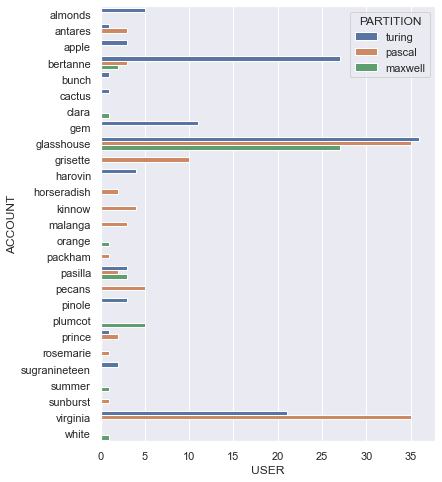

In [39]:
sns.set(rc={"figure.figsize":(6, 8)})
sns.barplot(
             x='USER',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['USER']
                    .nunique()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

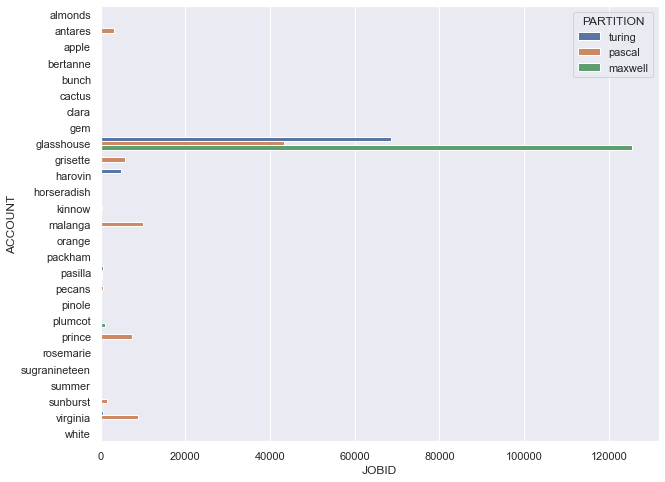

In [42]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='JOBID',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['JOBID']
                    .nunique()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

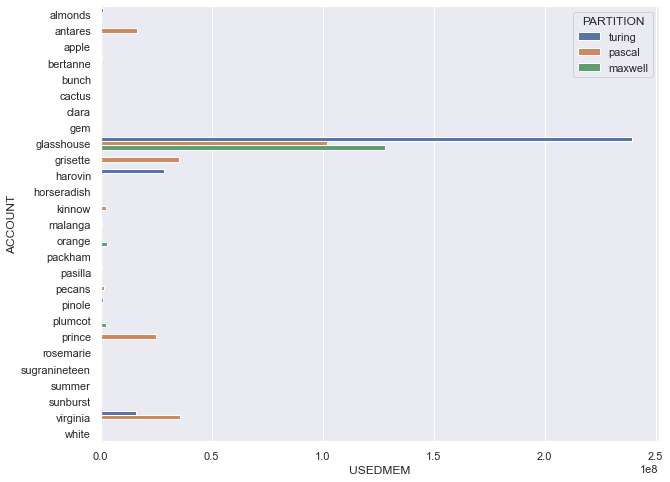

In [45]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='USEDMEM',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['USEDMEM']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

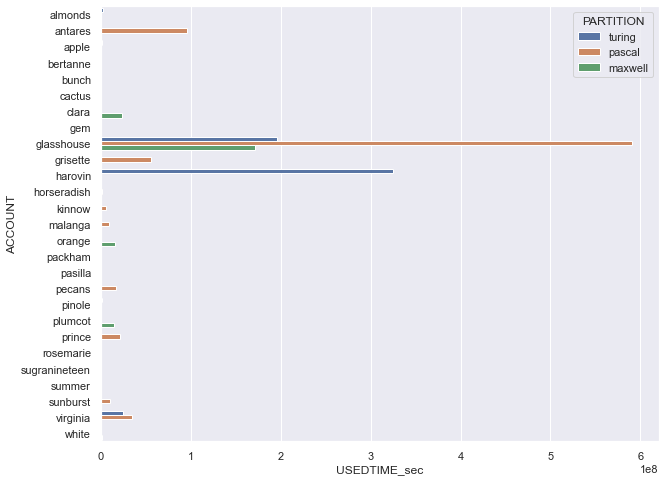

In [46]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='USEDTIME_sec',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['USEDTIME_sec']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

In [28]:
#number of jobs either completed, failed, or ran out of memory for each user
user_counts = (
    accre_gpu
    .groupby('PARTITION')[['ACCOUNT', 'USER']]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={0:'job_count'})
)
user_counts

,PARTITION,ACCOUNT,USER,job_count
0,maxwell,glasshouse,marnie,112903
1,maxwell,glasshouse,collins,4869
2,maxwell,glasshouse,erick,4553
3,maxwell,glasshouse,treva,1538
4,maxwell,plumcot,porsha,744
...,...,...,...,...
262,turing,gem,jefferey,1
263,turing,gem,jerrad,1
264,turing,gem,leyla,1
265,turing,gem,osborne,1


In [24]:
#total amount of time used for all jobs either completed, failed, or ran out of memory for each user
user_time = (
    accre_gpu
    .groupby(['PARTITION', 'ACCOUNT', 'USER'])['USEDTIME']
    .sum()
    .to_frame()
    .reset_index()
    .rename(columns={0:'job_count'})
)
user_time

,PARTITION,ACCOUNT,USER,USEDTIME
0,maxwell,bertanne,abigail,1 days 03:46:59
1,maxwell,bertanne,ari,0 days 00:00:00
2,maxwell,clara,suzanna,269 days 07:47:09
3,maxwell,glasshouse,abigail,18 days 06:47:17
4,maxwell,glasshouse,alexandre,0 days 00:01:21
...,...,...,...,...
262,turing,virginia,micayla,5 days 14:42:48
263,turing,virginia,olga,12 days 10:09:35
264,turing,virginia,suzy,0 days 01:41:17
265,turing,virginia,tracy,9 days 02:49:31


In [25]:
#total amount of memory used for all jobs either completed, failed, or ran out of memory for each user
user_memory = (
    accre_gpu
    .groupby(['PARTITION', 'ACCOUNT', 'USER'])['USEDMEM']
    .sum()
    .to_frame()
    .reset_index()
    .rename(columns={0:'job_count'})
)
user_memory

,PARTITION,ACCOUNT,USER,USEDMEM
0,maxwell,bertanne,abigail,38245.42
1,maxwell,bertanne,ari,400.53
2,maxwell,clara,suzanna,18972.34
3,maxwell,glasshouse,abigail,290807.50
4,maxwell,glasshouse,alexandre,159.86
...,...,...,...,...
262,turing,virginia,micayla,48992.27
263,turing,virginia,olga,4452611.03
264,turing,virginia,suzy,14233.31
265,turing,virginia,tracy,873030.38


In [63]:
from functools import reduce

dfs=[user_counts, user_memory, user_time]

user_details = reduce(lambda left, right: pd.merge(left, right), dfs)

user_details['mem_per_job'] = user_details['USEDMEM']/user_details['job_count']
user_details['time_per_job'] = user_details['USEDTIME']/user_details['job_count']

user_details['time_weighted_jobs'] = (user_details['USEDTIME'].dt.total_seconds()/86400) * (user_details['job_count'])

user_details

,PARTITION,ACCOUNT,USER,job_count,USEDMEM,USEDTIME,mem_per_job,time_per_job,time_weighted_jobs
0,maxwell,glasshouse,marnie,112903,93997987.46,210 days 12:00:06,832.555268,0 days 00:02:41.087003888,2.376609e+07
1,maxwell,glasshouse,collins,4869,23709038.38,670 days 16:07:29,4869.385578,0 days 03:18:21.016430478,3.265501e+06
2,maxwell,glasshouse,erick,4553,513230.78,387 days 07:08:29,112.723650,0 days 02:02:29.551724137,1.763366e+06
3,maxwell,glasshouse,treva,1538,4578881.95,11 days 12:56:36,2977.166417,0 days 00:10:48.241872561,1.774745e+04
4,maxwell,plumcot,porsha,744,2484606.16,144 days 04:51:50,3339.524409,0 days 04:39:06.115591397,1.072868e+05
...,...,...,...,...,...,...,...,...,...
262,turing,gem,jefferey,1,3626.66,0 days 00:08:22,3626.660000,0 days 00:08:22,5.810185e-03
263,turing,gem,jerrad,1,7.85,0 days 00:00:09,7.850000,0 days 00:00:09,1.041667e-04
264,turing,gem,leyla,1,12139.35,0 days 00:40:28,12139.350000,0 days 00:40:28,2.810185e-02
265,turing,gem,osborne,1,3626.27,0 days 00:10:44,3626.270000,0 days 00:10:44,7.453704e-03


In [36]:
user_details.groupby('PARTITION')['job_count'].nlargest(10)

PARTITION     
maxwell    0      112903
           1        4869
           2        4553
           3        1538
           4         744
           5         489
           6         423
           7         238
           8         171
           9         164
pascal     41      24777
           42       9851
           43       8413
           44       7403
           45       7115
           46       3185
           47       2840
           48       2626
           49       2492
           50       1609
turing     148     58931
           149      4266
           150      3911
           151      1676
           152      1442
           153       605
           154       424
           155       405
           156       253
           157       225
Name: job_count, dtype: int64

In [58]:
user_details.groupby('PARTITION')['USEDTIME'].nlargest(10)

PARTITION     
maxwell    1      670 days 16:07:29
           5      437 days 13:30:04
           2      387 days 07:08:29
           15     269 days 07:47:09
           0      210 days 12:00:06
           17     191 days 10:04:21
           4      144 days 04:51:50
           10      92 days 13:14:48
           8       49 days 16:55:19
           9       30 days 13:21:26
pascal     45    1505 days 08:44:13
           52    1478 days 23:04:52
           53    1363 days 23:05:35
           48    1065 days 16:56:51
           47     897 days 04:25:34
           54     423 days 05:53:09
           57     365 days 22:41:25
           44     251 days 07:52:27
           64     220 days 02:42:49
           60     161 days 22:11:48
turing     150   3003 days 05:30:24
           152    970 days 10:32:30
           157    414 days 00:37:34
           148    388 days 04:32:28
           155    340 days 18:32:33
           151    267 days 06:25:06
           162    171 days 01:18:02
           15

In [59]:
user_details.groupby('PARTITION')['USEDMEM'].nlargest(10)

PARTITION     
maxwell    0      9.399799e+07
           1      2.370904e+07
           3      4.578882e+06
           17     3.090962e+06
           4      2.484606e+06
           16     1.378470e+06
           13     1.039390e+06
           9      8.502190e+05
           18     6.655417e+05
           2      5.132308e+05
pascal     41     3.697431e+07
           45     3.141991e+07
           43     2.671758e+07
           44     2.504465e+07
           49     2.367889e+07
           46     1.703292e+07
           48     1.472241e+07
           54     7.618849e+06
           63     5.381814e+06
           74     5.199637e+06
turing     148    1.980931e+08
           150    2.422443e+07
           151    1.973711e+07
           153    8.619658e+06
           174    4.452611e+06
           160    2.771791e+06
           163    2.548617e+06
           158    2.536648e+06
           175    2.428148e+06
           190    2.132679e+06
Name: USEDMEM, dtype: float64

In [64]:
user_details.groupby('PARTITION')['time_weighted_jobs'].nlargest(10)

PARTITION     
maxwell    0      2.376609e+07
           1      3.265501e+06
           2      1.763366e+06
           5      2.139681e+05
           4      1.072868e+05
           15     2.073798e+04
           3      1.774745e+04
           17     1.416506e+04
           10     1.295727e+04
           8      8.499569e+03
pascal     45     1.071067e+07
           48     2.798544e+06
           47     2.548004e+06
           41     2.535090e+06
           52     2.123789e+06
           53     1.898635e+06
           44     1.860582e+06
           42     7.923516e+05
           43     6.354839e+05
           54     3.631444e+05
turing     148    2.287638e+07
           150    1.174563e+07
           152    1.399373e+06
           151    4.479402e+05
           149    4.092817e+05
           155    1.380129e+05
           157    9.315587e+04
           156    2.488330e+04
           162    2.394759e+04
           153    1.089405e+04
Name: time_weighted_jobs, dtype: float64

#### 5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [49]:
accre_gpu.loc[accre_gpu['REQTIME'] == '5 days']['ACCOUNT'].value_counts()

glasshouse     10143
virginia        8514
harovin         4434
antares         1442
grisette         870
plumcot          739
pecans           506
horseradish       47
clara             46
apple             44
kinnow            37
almonds           15
white              5
bertanne           4
Name: ACCOUNT, dtype: int64

In [66]:
accre_gpu.loc[accre_gpu['time_dif'] >= '1 day']['ACCOUNT'].value_counts()

glasshouse       21620
malanga           9889
virginia          8661
harovin           3976
grisette          3200
antares           1743
sunburst          1484
plumcot            751
pecans             503
almonds            106
cactus             101
kinnow              64
horseradish         46
apple               43
rosemarie           31
orange              28
clara               18
pinole               9
bertanne             7
sugranineteen        6
pasilla              3
packham              3
white                3
Name: ACCOUNT, dtype: int64

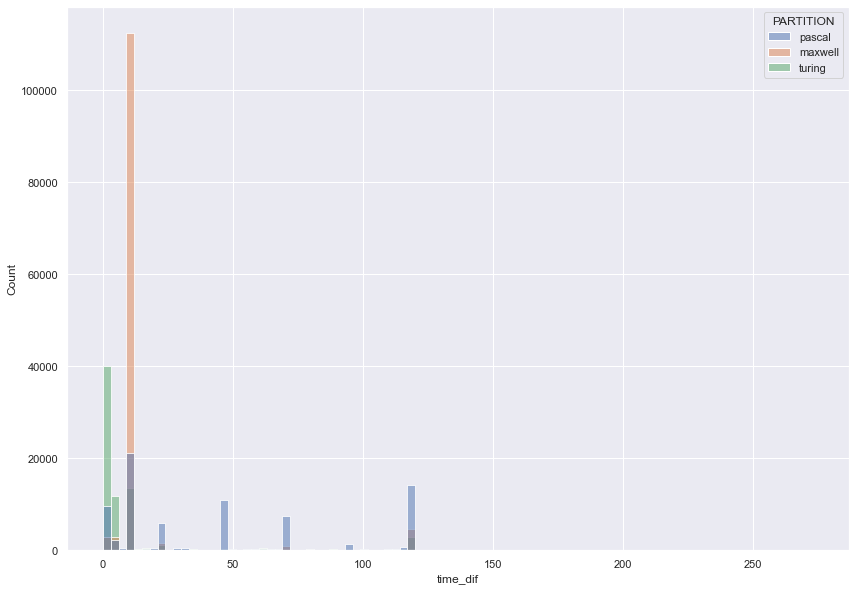

In [91]:
sns.set(rc={"figure.figsize":(14, 10)})
sns.histplot(
    data = accre_gpu.loc[accre_gpu['time_dif'] >= '0 day'], 
    x = (accre_gpu['time_dif'].astype('timedelta64[h]')),
    binwidth=3,
    hue = 'PARTITION'
);